# PoliDuckies
A notebook with the complete pipeline

### Standard imports

In [18]:
import os 
branch = "daffy" #@param ['master', 'daffy']

if not os.path.isdir('gym-duckietown') and not os.path.isdir('../gym-duckietown'):
  !git clone --branch {branch} https://github.com/duckietown/gym-duckietown.git
  !pip3 install -e gym-duckietown
if "/gym-duckietown" not in os.getcwd():
  os.chdir('gym-duckietown')
  
!apt install xvfb -y
!pip3 install pyvirtualdisplay
!pip install pyglet==1.5.14
!pip install duckietown-gym-daffy
!pip install poliduckie-segmentation

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
xvfb is already the newest version (2:21.1.3-2ubuntu2.9).
0 upgraded, 0 newly installed, 0 to remove and 92 not upgraded.


In [1]:
from pyvirtualdisplay import Display
import numpy as np
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay
%matplotlib inline

## used to copy the model to the gdrive folder
import shutil

import cv2
import gym
import gym_duckietown

# Gym has a built in logger to log information. The information is split in importance levels, from highest to lowest:
# CRITICAL, ERROR, WARNING, INFO, DEBUG, NOTSET
# To stop gym from printing many verbose NOTSET, INFO and DEBUG messages we let it print only level WARNING or higher messages
import logging
gym_duckietown.logger.setLevel(logging.WARNING)

DEBUG:commons:version: 6.2.4 *
DEBUG:typing:version: 6.2.3
DEBUG:duckietown_world:duckietown-world version 6.4.3 path /usr/local/lib/python3.9/dist-packages
DEBUG:geometry:PyGeometry-z6 version 2.1.4 path /usr/local/lib/python3.9/dist-packages
DEBUG:aido_schemas:aido-protocols version 6.1.1 path /usr/local/lib/python3.9/dist-packages
DEBUG:nodes:version 6.2.17 path /usr/local/lib/python3.9/dist-packages pyparsing 2.4.7
DEBUG:gym-duckietown:gym-duckietown version 6.1.34 path /usr/local/lib/python3.9/dist-packages



{'audio': ('xaudio2', 'directsound', 'openal', 'pulse', 'silent'), 'debug_font': False, 'debug_gl': True, 'debug_gl_trace': False, 'debug_gl_trace_args': False, 'debug_graphics_batch': False, 'debug_lib': False, 'debug_media': False, 'debug_texture': False, 'debug_trace': False, 'debug_trace_args': False, 'debug_trace_depth': 1, 'debug_trace_flush': True, 'debug_win32': False, 'debug_x11': False, 'graphics_vbo': True, 'shadow_window': True, 'vsync': None, 'xsync': True, 'xlib_fullscreen_override_redirect': False, 'darwin_cocoa': True, 'search_local_libs': True}


In [2]:
map_name = "Duckietown-small_loop-v0"

### Methods

In [3]:
from poliduckie_segmentation.segmentation import Segmentation

seg = Segmentation()

def segmentation(image):
  """
    Returns the image from the simulation with the segmentation

    Image: np.Array
    ------
    Image: np.Array
  """
  resized = cv2.resize(image, (320, 240))
  return seg.predict(resized)

2023-04-02 17:51:55.042130: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-04-02 17:51:55.045138: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-02 17:51:55.094453: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2023-04-02 17:51:55.095508: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-04-02 17:51:56.058530: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Co

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 240, 320, 3  0           []                               
                                )]                                                                
                                                                                                  
 lambda (Lambda)                (None, 240, 320, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv2d (Conv2D)                (None, 240, 320, 16  448         ['lambda[0][0]']                 
                                )                                                                 
                                                                                              

In [56]:
from poliduckie_segmentation import BirdEyeView

matrixPath = './BirdEyeMatrices/SegmentationOutput.pkl'
birdeye = BirdEyeView(path = matrixPath)

def birdEyeTransform(image):
  """
    Returns the image from the simulation with the bird eye view

    Image: np.Array
    ------
    Image: np.Array
  """
  return birdeye.computeBirdEye(image)

In [34]:
from poliduckie_segmentation.line_extraction import LineExtraction

lineExtraction_ = LineExtraction()

def lineExtraction(image, n_points=100, mode="bezier", bezier_degree=3):
  """
    Returns the central line extracted as a numpy array. The mode can be either "bezier" or "spline"

    Image: np.Array
    n_points: int
    mode: str
    bezier_degree: int
    ------
    Line: np.Array
  """
  if mode == "bezier":
    bezier_points = lineExtraction_.bezier_fit(image, degree=bezier_degree, nPoints=n_points)
    return bezier_points
  
  elif mode == "spline":
    spline_points = lineExtraction_.spline_interpolation(image, nPoints=n_points)
    return spline_points

In [5]:
def computeReference(line, N):
  """
    Returns the references in meters
    Reference is a list with dimension (2, N)
    N is the prediction horizon of the MPC

    Line: np.Array
    N: int
    ------
    reference: List[[List[Float], List[Float]]]
  """
  # extract x, y of reference
  # TODO

  reference = [[x]*N, [y]*N]
  pass

In [6]:
from poliduckie_segmentation.control import MPC
M = MPC()

def runMpc(state, reference):
  """
    Returns the control inputs to give to the car.
    State is [x, y, theta, v, w]
    Reference is a list with dimension (2, N)

    state: [Float, Float, Float, Float, Float]
    reference: List[[List[Float], List[Float]]]
    ------
    u: List[Float, Float]
  """
  return M.mpc(state, reference)

In [61]:
imageVisualization = 'Plt' #@param ['Plt', 'CV2']

def plt_imshow(image):
  plt.imshow(image)
  plt.show()


if imageVisualization == 'CV2':
  from google.colab.patches import cv2_imshow
  imshow = cv2_imshow
else:
  imshow = plt_imshow

### Simulation

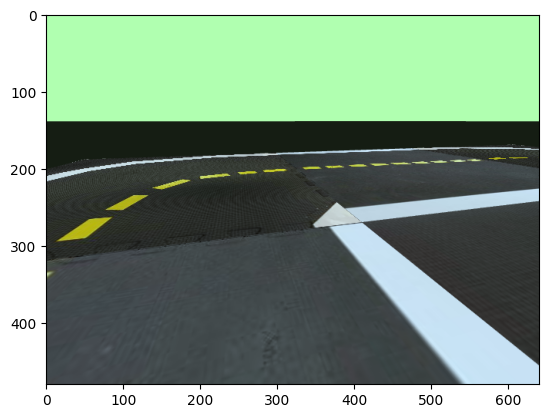

In [64]:
# display = Display(visible=0, size=(1400, 900))
# display.start()
env = gym.make(map_name)
imshow(env.reset())

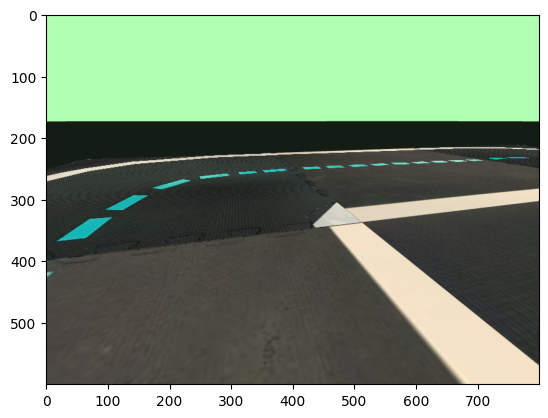

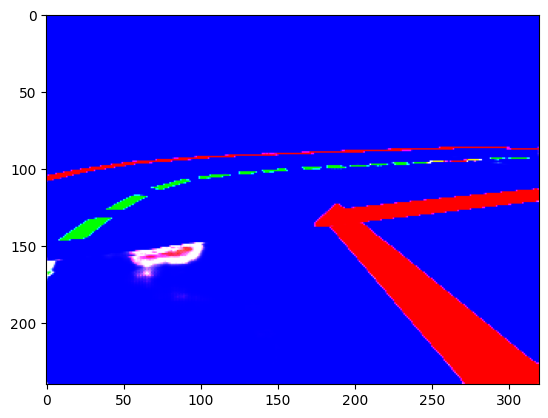

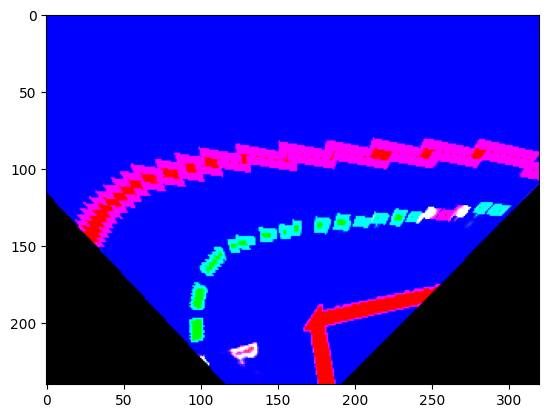

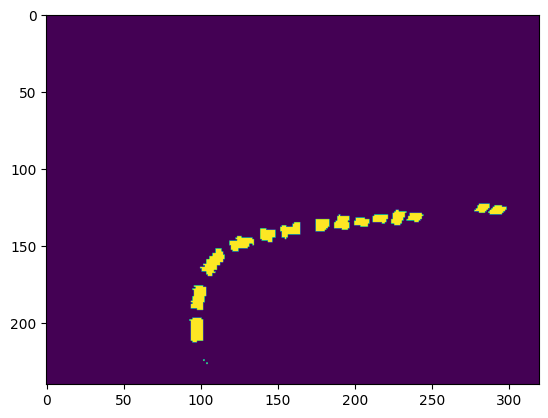

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


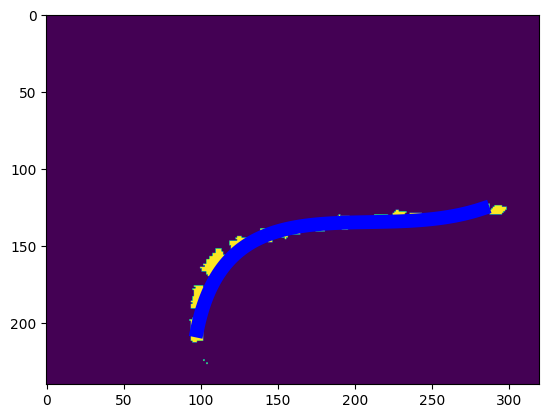

TypeError: computeReference() missing 1 required positional argument: 'N'

In [67]:
from poliduckie_segmentation.model import Model
%matplotlib inline

# State X = [x, y, angle, longitudinal speed, angular speed]
state = [0,0,0,0,0]

F = Model()

image_recording = []

for _ in range(100):
  image = env.render(mode="rgb_array")
  image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
  imshow(image)

  image_recording.append(image)
  image_segmentation = segmentation(image)[0]*255
  imshow(image_segmentation)

  image_birdeye = birdEyeTransform(image_segmentation)
  imshow(image_birdeye)

  dottedLineMask = cv2.threshold(image_birdeye[:, :, 1], 70, 255, cv2.THRESH_BINARY)[1]
  imshow(dottedLineMask)

  line = lineExtraction(dottedLineMask, mode='bezier')
  plt.imshow(dottedLineMask)
  plt.plot(line[0], line[1], color='blue', linewidth=10)
  plt.show()

  reference = computeReference(line)
  action = runMpc(state, reference)
  state = F.step(*state, action)
  env.step(action)